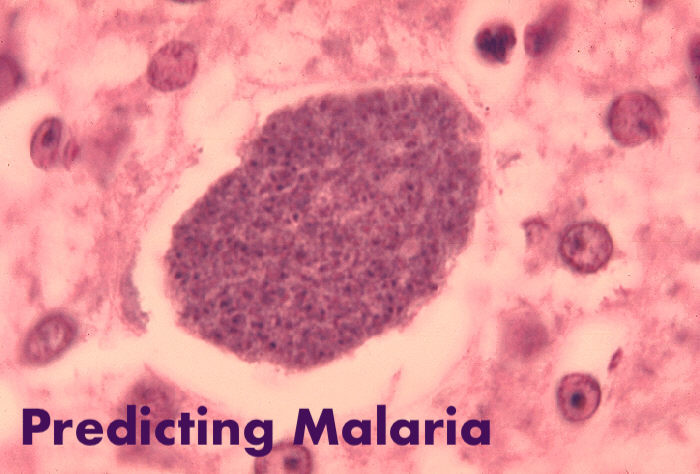

# Predicting Malaria in Blood Cells
**Author:** Jonathan Fetterolf

## Business Understanding
According to the latest [World Malaria Report](https://www.who.int/publications/i/item/9789240064898) published by the [World Health Organization](https://www.who.int/news-room/fact-sheets/detail/malaria), there were 247 million cases of malaria in 2021 compared to 245 million cases in 2020. The estimated number of malaria deaths stood at 619,000 in 2021 compared to 625,000 in 2020. An early diagnosis and subsequently early treatment of malaria will help doctors practicing in araea with high rates of malaria infection and malaria deaths. Four African countries accounted for over half of all malaria deaths worldwide: Nigeria (31.3%), the Democratic Republic of the Congo (12.6%), United Republic of Tanzania (4.1%) and Niger (3.9%). 
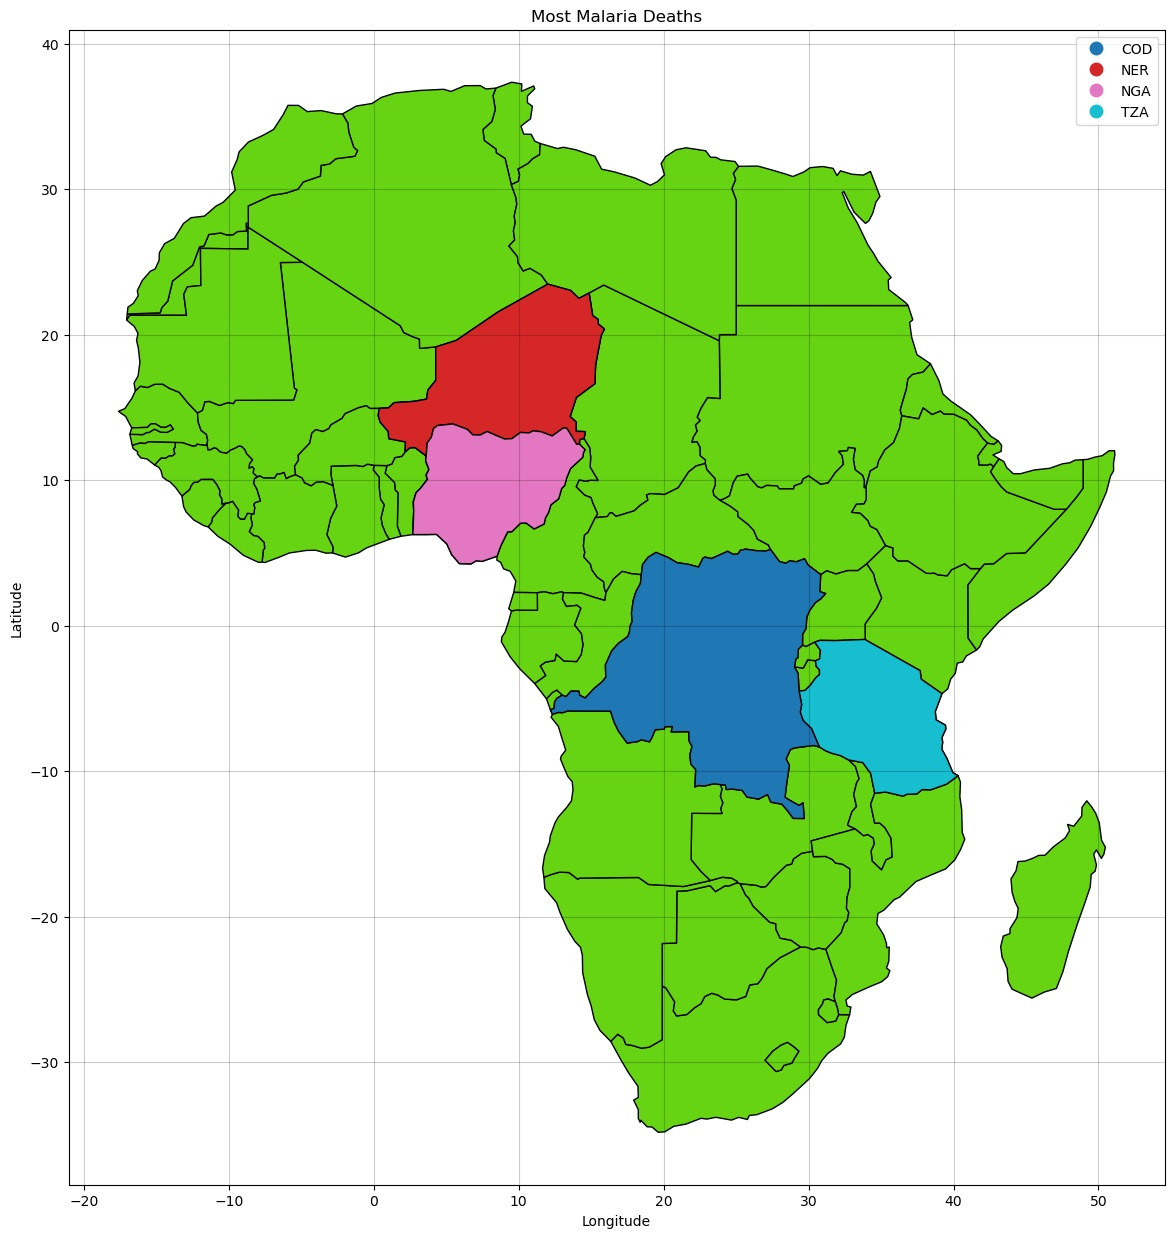

### Business Problem
The [WHO | Regional Office for Africa](https://www.afro.who.int/health-topics/malaria) recognizes that malaria is going undiagnosed and subsequently untreated in areas where the parasite is prevalent and the resources to diagnose and treat it are the lowest. The WHO wants to create a model that can accurately predict whether or not a cell from stained blood smear is infected with malaria in order to more effectively diagnose and treat malaria in the population. 

This application can save lives. According to the [CDC](https://www.cdc.gov/malaria/diagnosis_treatment/clinicians1.html#:~:text=The%20preferred%20antimalarial%20for%20interim,not%20adequate%20for%20interim%20treatment.): in an ideal situation malaria treatment should not be initiated until the diagnosis has been established by laboratory testing. “Presumptive treatment”, i.e., without prior laboratory confirmation, should be reserved for extreme circumstances, such as strong clinical suspicion of severe disease in a setting where prompt laboratory diagnosis is not available. Doctors will still be needed to take blood and provide treatments. Histologists will still be required to prepare slides and confirm the diagnoses. This technology will simply make their operations more effiecient and allow them to dianose and treat more patients.

### Diagnosis
Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide. Prior to examination, the specimen is stained (most often with the Giemsa stain) to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria. However, it depends on the quality of the reagents, of the microscope, and on the experience of the laboratorian.

In the case of identifying cells parasitized by malaria, the Giemsa stain is particularly useful because the stain binds to the parasite's chromatin and makes it stand out under a microscope.

### Cost of Errors
 The [CDC](https://www.cdc.gov/malaria/diagnosis_treatment/diagnosis.html) states that Malaria must be recognized promptly in order to treat the patient in time and to prevent further spread of infection in the community via local mosquitoes. Malaria should be considered a potential medical emergency and should be treated accordingly. *Delay in diagnosis and treatment is a leading cause of death in malaria patients in the United States*.

When considering the diagnosis of malaria, false negatives are more costly than false positives for a few reasons: 
- Treatment is relatively cheap ([USD $3-6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3844618/) as of 2013)
- Side effects are minimal
- Undiagnosed malaria can lead community transmission and eventually to death

Recall will be a very important metric when evaluating the models as the goal is minimizing false negatives.

## Notebook Setup in Google Colaboratory

### Mounting Your Drive
In this notebook, image files are accessed through [Google Drive](https://www.google.com/drive/). In order to run this notebook you can upload the data found from [TensorFlow](https://www.tensorflow.org/datasets/catalog/malaria) or [Kaggle](https://www.tensorflow.org/datasets/catalog/malaria) to your Google Drive and access it from there.

Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Required Installs

In [2]:
!pip install tensorflow
!pip install keras
!pip install tensorflow-datasets
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00


### Required Imports

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import load

from tensorflow import keras
tfds.disable_progress_bar()

from keras import layers, models
from keras.metrics import Precision, Recall, Accuracy, BinaryAccuracy
from keras_tuner import RandomSearch
from keras.models import load_model

from keras.layers.preprocessing.image_preprocessing import RandomBrightness, RandomContrast

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, get_file

import os
import cv2

from PIL import Image
import matplotlib.pyplot as plt

## Exploring Data
The data originally comes from the [National Institute of Health's National Library of Medicine](https://lhncbc.nlm.nih.gov/) (NLM - NIH). It can be found at [TensorFlow](https://www.tensorflow.org/datasets/catalog/malaria) or [Kaggle](https://www.tensorflow.org/datasets/catalog/malaria). The data consists of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. Having equal samples is important in the training of this model to avoid class bias in predictions generated by the model. 

Note: I have constructed smaller datasets to require less processing power while running the notebook. These datasets also have equal instances of parasitized and uninfected cells.

I have also brought in auxiliary data that *is not* used in the modeling process. It's used to generate statistics and visualizations about malaria cases and deaths from around the world. This data is provided by the WHO and can be found in the following places: 
- [Estimated Cases](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimated-number-of-malaria-cases)
- [Estimated Deaths](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimated-number-of-malaria-deaths)
- [Confirmed Cases](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/number-confirmed-malaria-cases)

(To access the data in CSV format, navigate to the data panel and right click the `EXPORT DATA in CSV format:` link and save link.)


### Loading Images

In [4]:
batch_size = 32
imgage_dim = 64
image_size = (imgage_dim, imgage_dim)

# Uncomment to change to desired directory

# 200 Image Directory: "/content/drive/MyDrive/malaria_dataset2/"
# img_dir = '/content/drive/MyDrive/malaria_dataset2'

# 2000 Image Directory: "/content/drive/MyDrive/malaria_dataset3/"
img_dir = '/content/drive/MyDrive/malaria_dataset3'

# 27,558 Image Directory: "/content/drive/MyDrive/malaria_dataset/" for full dataset
# img_dir = '/content/drive/MyDrive/malaria_dataset'

mal_ds = tf.keras.utils.image_dataset_from_directory(img_dir,
                                                         labels='inferred',
                                                         label_mode='int', 
                                                         color_mode='rgb',
                                                         batch_size=batch_size,
                                                         image_size=image_size,
                                                         shuffle=True,
                                                         seed=42,
                                                         subset=None)

Found 2000 files belonging to 2 classes.


### Visualizing Data

Example Images

When examining a Giemsa-stained blood sample for evidence of malaria, the infected red blood cells (RBCs) will display characteristic morphological changes. These changes are due to the presence of the Plasmodium parasite within the RBCs.

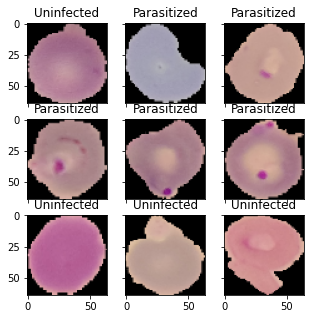

In [5]:
# visualizing data
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(5,5))
 
for images, labels in mal_ds.take(1):
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            ax[i][j].set_title(mal_ds.class_names[labels[i*3+j]])
plt.show()

Visualize Preprocesses & Augmentation

Resizing images normalizes the input sizes which will regularize the training process while rescaling images helps the CNN to learn more effectively. 

Using this data augmentation will help avoid overfitting by creating unseen training examples from the existing ones, thereby increasing the size of the training dataset.

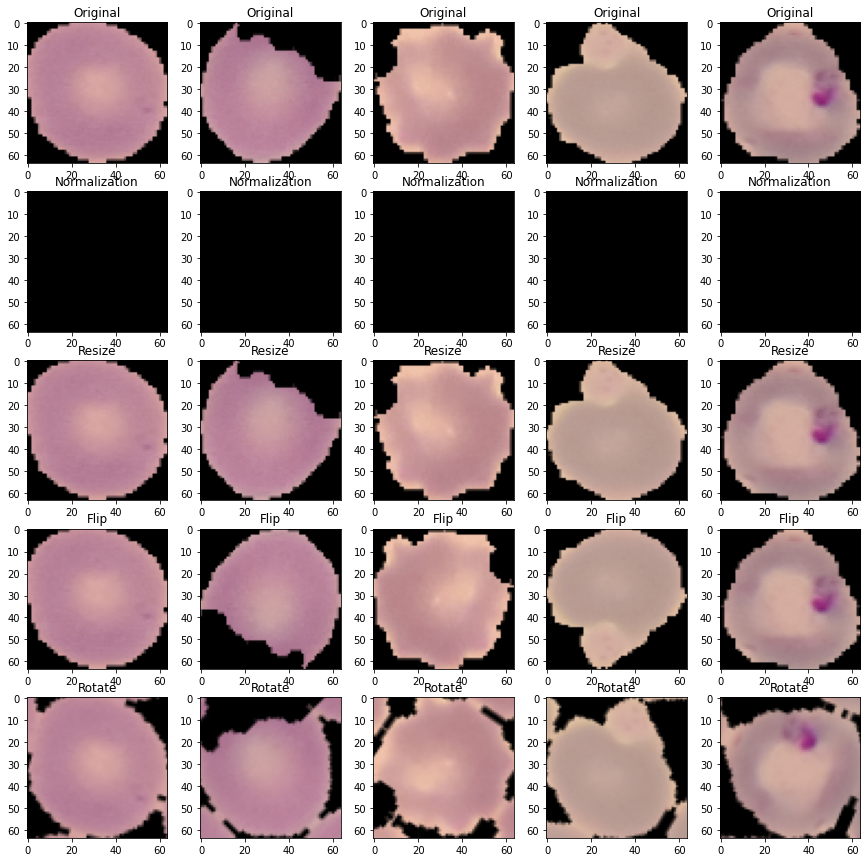

In [7]:
# create a preprocessing layers
bright_range = (-.08, .8)
out_height, out_width = 64, 64
resize = tf.keras.layers.Resizing(out_height, out_width)
normalization = tf.keras.layers.Rescaling(1./255)  # rescale pixel values to [0, 1]
flip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=None)
rotate = tf.keras.layers.RandomRotation(0.2)

fig, ax = plt.subplots(5, 5, figsize=(15,15))
 
for images, labels in mal_ds.take(1):
    for i in range(5):
        # original
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("Original")

        # normalization
        ax[1][i].imshow(normalization(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("Normalization")

        # resize
        ax[2][i].imshow(resize(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("Resize")

        # flip
        ax[3][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("Flip")

        # rotate
        ax[4][i].imshow(rotate(images[i]).numpy().astype("uint8"))
        ax[4][i].set_title("Rotate")

# images will display original examples then examples of each preprocess
plt.show()

## Data Augmentation

Create Pipeline Layers

In [8]:
out_height, out_width = 64, 64
resize_and_rescale = keras.Sequential([
    layers.Resizing(out_height, out_width),
    layers.Rescaling(1./255)
    ])

data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical", seed=None),
    layers.RandomRotation(.2)
    ])


Batch Data

In [9]:
data_iterator = mal_ds.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
# images [0], labels [1]
len(batch)

2

There are 32 images in a batch. Each image has a resolution of 64x64 with 3 color channels (Red, Green, & Blue).

In [12]:
# images represented by numpy arrays
batch[0].shape

(32, 64, 64, 3)

Example of batch labels:

In [13]:
# labels
batch[1]

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0], dtype=int32)

Number of batches in the dataset.

In [14]:
num_batches = len(mal_ds)
num_batches

63

Making sure all batches are used: 

In [15]:
# need to adjust to use all batches
train_size = int(len(mal_ds)*0.7)
val_size = int(len(mal_ds)*0.2)+1
test_size = int(len(mal_ds)*0.1)

In [16]:
train_size, val_size, test_size

(44, 13, 6)

In [17]:
num_batches == train_size + val_size + test_size

True

Segmenting dataset using all batches:

In [18]:
train = mal_ds.take(train_size)
val = mal_ds.skip(train_size).take(val_size)
test = mal_ds.skip(train_size + val_size).take(test_size)

In [19]:
train_size == len(train), val_size == len(val), test_size == len(test)

(True, True, True)

## Baseline Model
The data I use for this problem is evenly balanced. A baseline model, choosing all cells to 'Uninfected' results in an accuracy of 50%.

## Convolutional Neural Networks
(CNNs)

### Model 1

#### Set Up
Model 1 is a fairly simple convolutional neural network (CNN) *without* data augmentation.

In [22]:
# baseline model, no data augmentation, just resizing and rescaling
input_shape = (64,64,3)

model = keras.Sequential([
    
    # input layer
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(2,2),

    #resize & rescale
    resize_and_rescale,

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

#### Compile

Parameters
- Optimizer: `adam`
- Loss: `binary crossentropy`
- Metrics: `accuracy`, `false negatives`
- Total params: `6,479,873`
- Trainable params: `6,479,873`
- Non-trainable params: `0`


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives')])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)       

#### Train
Epochs: 25

In [29]:
hist1 = model.fit(x=train, epochs=25, validation_data=val, verbose=1, shuffle=True)

Epoch 1/25
44/44 [==============================] - 2s 32ms/step - loss: 0.0288 - accuracy: 0.9886 - false_negatives: 4.0000 - val_loss: 0.1451 - val_accuracy: 0.9519 - val_false_negatives: 5.0000
Epoch 2/25
44/44 [==============================] - 1s 31ms/step - loss: 0.0260 - accuracy: 0.9943 - false_negatives: 3.0000 - val_loss: 0.0765 - val_accuracy: 0.9880 - val_false_negatives: 3.0000
Epoch 3/25
44/44 [==============================] - 2s 32ms/step - loss: 0.0131 - accuracy: 0.9957 - false_negatives: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9712 - val_false_negatives: 9.0000
Epoch 4/25
44/44 [==============================] - 2s 33ms/step - loss: 0.0291 - accuracy: 0.9929 - false_negatives: 6.0000 - val_loss: 0.0934 - val_accuracy: 0.9615 - val_false_negatives: 4.0000
Epoch 5/25
44/44 [==============================] - 1s 31ms/step - loss: 0.0204 - accuracy: 0.9957 - false_negatives: 1.0000 - val_loss: 0.0974 - val_accuracy: 0.9784 - val_false_negatives: 3.0000
Epoch 6/25
44/4

#### Results

In [30]:
hist1.history

{'loss': [0.028775326907634735,
  0.026015641167759895,
  0.013060289435088634,
  0.029122425243258476,
  0.020443443208932877,
  0.017511051148176193,
  0.006987637374550104,
  0.010643662884831429,
  0.009441346861422062,
  0.03850948438048363,
  0.01901491917669773,
  0.03610058128833771,
  0.033758994191884995,
  0.019668901339173317,
  0.012751269154250622,
  0.04175994172692299,
  0.015733681619167328,
  0.022790925577282906,
  0.011243589222431183,
  0.005585109815001488,
  0.0029342842753976583,
  0.005724163725972176,
  0.0020401389338076115,
  0.010479838587343693,
  0.004234364256262779],
 'accuracy': [0.9886363744735718,
  0.9943181872367859,
  0.9957386255264282,
  0.9928977489471436,
  0.9957386255264282,
  0.9936079382896423,
  1.0,
  0.9957386255264282,
  0.9985795617103577,
  0.9836647510528564,
  0.9928977489471436,
  0.9893465638160706,
  0.9886363744735718,
  0.9943181872367859,
  0.9957386255264282,
  0.9865056872367859,
  0.9964488744735718,
  0.9928977489471436,


#### Testing Precision, Recall, & Binary Accuracy

In [31]:
pre = Precision()
re = Recall()
acc = Accuracy()


In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 114ms/step
Precision:1.0, Recall:0.9587628841400146, Accuracy:0.9772727489471436


#### Visualizing Results

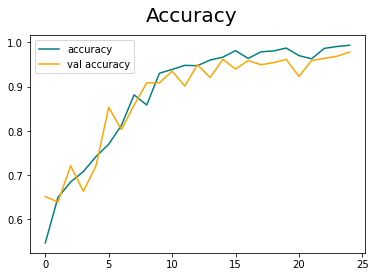

In [33]:
fig = plt.figure()
plt.plot(baseline.history['accuracy'], color='teal', label='accuracy')
plt.plot(baseline.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


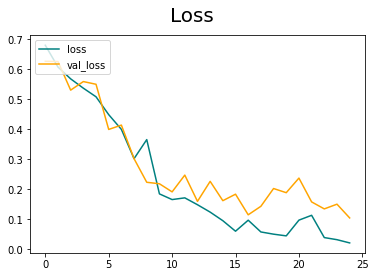

In [34]:
fig = plt.figure()
plt.plot(baseline.history['loss'], color='teal', label='loss')
plt.plot(baseline.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

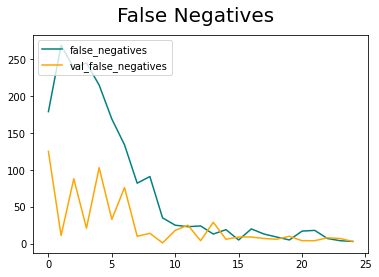

In [35]:
fig = plt.figure()
plt.plot(baseline.history['false_negatives'], color='teal', label='false_negatives')
plt.plot(baseline.history['val_false_negatives'], color='orange', label='val_false_negatives')
fig.suptitle('False Negatives', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Model 2

#### Set Up
This model has the same structure but adds in a data augmentation layer which will peform a random flip and random rotation on the image. 


In [36]:
model2 = keras.Sequential([

    # input layer
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(2,2),

    # augment data
    data_augmentation,

    # resize & rescale
    resize_and_rescale,

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

#### Compile
Parameters
- Optimizer: `adam`
- Loss: binary `crossentropy`
- Metrics: `accuracy`, `false negatives`
- Total params: `6,479,873`
- Trainable params: `6,479,873`
- Non-trainable params: `0`

In [37]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives')])
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 sequential_1 (Sequential)   (None, 31, 31, 32)        0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                  

#### Train
Epochs: 25

In [38]:
hist2 = model2.fit(x=train, epochs=25, validation_data=val, verbose=1, shuffle=True)

Epoch 1/25


44/44 [==============================] - 10s 109ms/step - loss: 0.6448 - accuracy: 0.6108 - false_negatives: 252.0000 - val_loss: 0.6180 - val_accuracy: 0.6274 - val_false_negatives: 17.0000
Epoch 2/25
44/44 [==============================] - 5s 106ms/step - loss: 0.6027 - accuracy: 0.6705 - false_negatives: 272.0000 - val_loss: 0.6753 - val_accuracy: 0.6322 - val_false_negatives: 149.0000
Epoch 3/25
44/44 [==============================] - 5s 105ms/step - loss: 0.5890 - accuracy: 0.6676 - false_negatives: 293.0000 - val_loss: 0.5459 - val_accuracy: 0.7284 - val_false_negatives: 101.0000
Epoch 4/25
44/44 [==============================] - 5s 105ms/step - loss: 0.5398 - accuracy: 0.7088 - false_negatives: 305.0000 - val_loss: 0.5530 - val_accuracy: 0.6947 - val_false_negatives: 101.0000
Epoch 5/25
44/44 [==============================] - 5s 103ms/step - loss: 0.5757 - accuracy: 0.6726 - false_negatives: 328.0000 - val_loss: 0.5864 - val_accuracy: 0.6659 - val_false_negatives: 55.0000
Ep

#### Results

In [39]:
hist2.history

{'loss': [0.6448363065719604,
  0.602685809135437,
  0.5889639258384705,
  0.5397510528564453,
  0.5757423043251038,
  0.5091472864151001,
  0.5030655860900879,
  0.5133054256439209,
  0.5168853402137756,
  0.46584710478782654,
  0.39334869384765625,
  0.3675854504108429,
  0.2950473129749298,
  0.3581373989582062,
  0.30423441529273987,
  0.3218831717967987,
  0.3354510962963104,
  0.2646605968475342,
  0.23239432275295258,
  0.22193588316440582,
  0.23633570969104767,
  0.2234882414340973,
  0.24665051698684692,
  0.2293047308921814,
  0.1855403482913971],
 'accuracy': [0.6107954382896423,
  0.6704545617103577,
  0.6676136255264282,
  0.7088068127632141,
  0.6725852489471436,
  0.7301136255264282,
  0.734375,
  0.7485795617103577,
  0.7563920617103577,
  0.7926136255264282,
  0.8259943127632141,
  0.8508522510528564,
  0.8877840638160706,
  0.8451704382896423,
  0.8785511255264282,
  0.8714488744735718,
  0.8565340638160706,
  0.9019886255264282,
  0.9112215638160706,
  0.92116475105

#### Testing Precision, Recall, & Binary Accuracy

In [40]:
pre = Precision()
re = Recall()
acc = Accuracy()


In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model2.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 112ms/step
Precision:0.9777777791023254, Recall:0.9166666865348816, Accuracy:0.9431818127632141


#### Visualizing Results

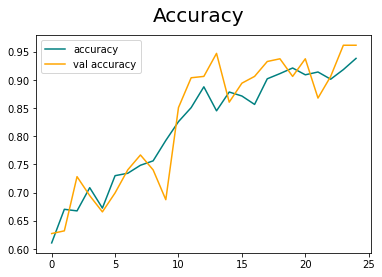

In [42]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


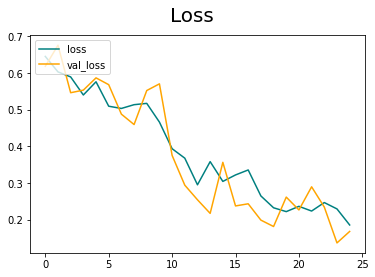

In [43]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

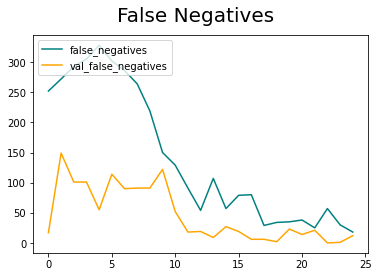

In [44]:
fig = plt.figure()
plt.plot(hist2.history['false_negatives'], color='teal', label='false_negatives')
plt.plot(hist2.history['val_false_negatives'], color='orange', label='val_false_negatives')
fig.suptitle('False Negatives', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Model 3
- Augmented Data
- More Layers
- Normalization
- More Dropouts

#### Set Up

In [45]:
model3 = keras.Sequential([
    # input layer
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(2,2),

    # augment data
    data_augmentation,

    # resize & rescale
    resize_and_rescale,

    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=.02),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=.02),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=.02),

    keras.layers.Flatten(),

    # hidden
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(0.2),

    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

#### Compile


In [46]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives')])
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 sequential_1 (Sequential)   (None, 31, 31, 32)        0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 32)       

#### Train

In [47]:
hist3 = model3.fit(x=train, epochs=25, validation_data=val, verbose=1, shuffle=True)

Epoch 1/25


44/44 [==============================] - 11s 112ms/step - loss: 0.6702 - accuracy: 0.7280 - false_negatives: 205.0000 - val_loss: 0.7061 - val_accuracy: 0.4784 - val_false_negatives: 216.0000
Epoch 2/25
44/44 [==============================] - 5s 107ms/step - loss: 0.4975 - accuracy: 0.7770 - false_negatives: 172.0000 - val_loss: 0.9729 - val_accuracy: 0.4712 - val_false_negatives: 220.0000
Epoch 3/25
44/44 [==============================] - 5s 113ms/step - loss: 0.3729 - accuracy: 0.8501 - false_negatives: 114.0000 - val_loss: 0.8258 - val_accuracy: 0.5457 - val_false_negatives: 4.0000
Epoch 4/25
44/44 [==============================] - 5s 109ms/step - loss: 0.3334 - accuracy: 0.8629 - false_negatives: 98.0000 - val_loss: 0.9486 - val_accuracy: 0.5192 - val_false_negatives: 2.0000
Epoch 5/25
44/44 [==============================] - 5s 110ms/step - loss: 0.2809 - accuracy: 0.8942 - false_negatives: 77.0000 - val_loss: 1.7864 - val_accuracy: 0.5144 - val_false_negatives: 3.0000
Epoch 6/

#### Results

In [48]:
hist3.history

{'loss': [0.6702069640159607,
  0.4975099265575409,
  0.37292003631591797,
  0.3333792984485626,
  0.2808982729911804,
  0.28897497057914734,
  0.2504747211933136,
  0.2506628632545471,
  0.2014113813638687,
  0.21958284080028534,
  0.19104929268360138,
  0.17362608015537262,
  0.177630215883255,
  0.17112289369106293,
  0.23618502914905548,
  0.15625281631946564,
  0.19226998090744019,
  0.17666274309158325,
  0.17443276941776276,
  0.13564904034137726,
  0.1379723697900772,
  0.167047917842865,
  0.1421632319688797,
  0.12239496409893036,
  0.1378304660320282],
 'accuracy': [0.7279829382896423,
  0.7769886255264282,
  0.8501420617103577,
  0.8629261255264282,
  0.8941761255264282,
  0.8913352489471436,
  0.8920454382896423,
  0.90625,
  0.9169034361839294,
  0.9176136255264282,
  0.9311079382896423,
  0.9339488744735718,
  0.9360795617103577,
  0.9296875,
  0.9133522510528564,
  0.9417613744735718,
  0.9275568127632141,
  0.9353693127632141,
  0.9353693127632141,
  0.953125,
  0.9474

#### Testing Precision, Recall, & Binary Accuracy

In [49]:
pre = Precision()
re = Recall()
acc = Accuracy()


In [50]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model3.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 172ms/step
Precision:0.0, Recall:0.0, Accuracy:0.4886363744735718


#### Results Visualization

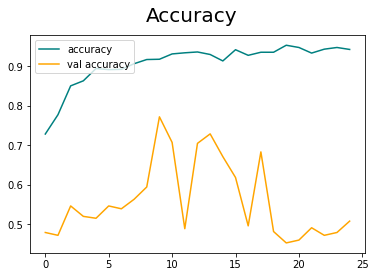

In [51]:
fig = plt.figure()
plt.plot(hist3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist3.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


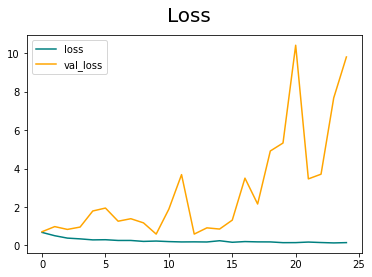

In [52]:
fig = plt.figure()
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

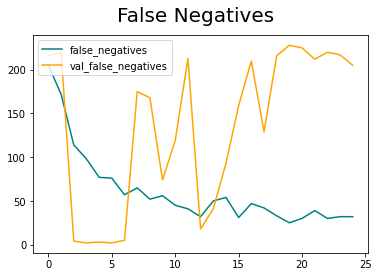

In [53]:
fig = plt.figure()
plt.plot(hist3.history['false_negatives'], color='teal', label='false_negatives')
plt.plot(hist3.history['val_false_negatives'], color='orange', label='val_false_negatives')
fig.suptitle('False Negatives', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [54]:
# does not look like batch normalization helped going to try and tune the baseline

### Model 4

#### Set Up

In [55]:
model4 = keras.Sequential([
    # input layer
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(2,2),

    # augment data
    data_augmentation,

    # resize & rescale
    resize_and_rescale,

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),

    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),

    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),

    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

#### Compile
Parameters
- Optimizer: `adam`
- Loss: binary `crossentropy`
- Metrics: `accuracy`, `false negatives`
- Total params: `1,246,305`
- Trainable params: `1,246,305`
- Non-trainable params: `0`

In [56]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives')])
print(model4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 sequential_1 (Sequential)   (None, 31, 31, 32)        0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 128)       36992     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 128)      0         
 g2D)                                                 

#### Train

In [57]:
hist4 = model4.fit(x=train, epochs=25, validation_data=val, verbose=1, shuffle=True)

Epoch 1/25


44/44 [==============================] - 10s 109ms/step - loss: 0.6832 - accuracy: 0.5455 - false_negatives: 398.0000 - val_loss: 0.8709 - val_accuracy: 0.5505 - val_false_negatives: 1.0000
Epoch 2/25
44/44 [==============================] - 5s 108ms/step - loss: 0.6666 - accuracy: 0.5966 - false_negatives: 256.0000 - val_loss: 0.6498 - val_accuracy: 0.6514 - val_false_negatives: 65.0000
Epoch 3/25
44/44 [==============================] - 5s 105ms/step - loss: 0.6486 - accuracy: 0.6030 - false_negatives: 156.0000 - val_loss: 0.6079 - val_accuracy: 0.6562 - val_false_negatives: 39.0000
Epoch 4/25
44/44 [==============================] - 5s 107ms/step - loss: 0.6259 - accuracy: 0.6243 - false_negatives: 170.0000 - val_loss: 0.6353 - val_accuracy: 0.6755 - val_false_negatives: 53.0000
Epoch 5/25
44/44 [==============================] - 5s 107ms/step - loss: 0.5917 - accuracy: 0.6655 - false_negatives: 292.0000 - val_loss: 0.5721 - val_accuracy: 0.6659 - val_false_negatives: 34.0000
Epoch 

#### Results

In [58]:
hist4.history

{'loss': [0.6832230091094971,
  0.6665723323822021,
  0.6485686898231506,
  0.6259389519691467,
  0.591660737991333,
  0.6237375736236572,
  0.5950198769569397,
  0.5967851281166077,
  0.5727086663246155,
  0.5493279099464417,
  0.5612046718597412,
  0.5245980620384216,
  0.5432143807411194,
  0.5059679746627808,
  0.4949760138988495,
  0.37537825107574463,
  0.23226027190685272,
  0.16689345240592957,
  0.24568681418895721,
  0.1731933355331421,
  0.15966986119747162,
  0.14952149987220764,
  0.14655373990535736,
  0.13655322790145874,
  0.12444400042295456],
 'accuracy': [0.5454545617103577,
  0.5965909361839294,
  0.6029829382896423,
  0.6242897510528564,
  0.6654829382896423,
  0.6434659361839294,
  0.6690340638160706,
  0.6583806872367859,
  0.6818181872367859,
  0.7137784361839294,
  0.6960227489471436,
  0.7230113744735718,
  0.7123579382896423,
  0.7372159361839294,
  0.7578125,
  0.8423295617103577,
  0.9197443127632141,
  0.9474431872367859,
  0.9169034361839294,
  0.93892043

#### Testing Precision, Recall, & Binary Accuracy

In [59]:
pre = Precision()
re = Recall()
acc = Accuracy()


In [60]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model4.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 142ms/step
Precision:0.9888888597488403, Recall:0.9270833134651184, Accuracy:0.9545454382896423


#### Results Visualization

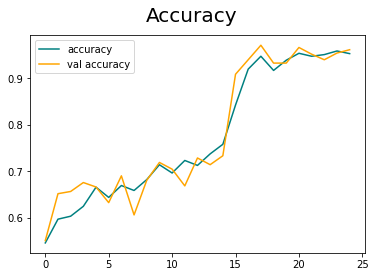

In [61]:
fig = plt.figure()
plt.plot(hist4.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist4.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


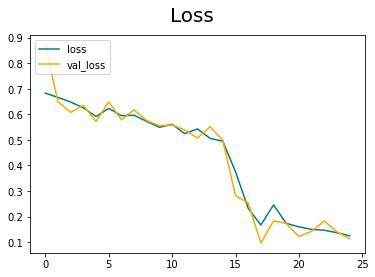

In [62]:
fig = plt.figure()
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

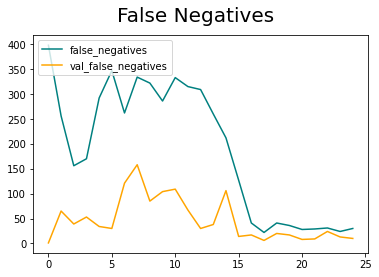

In [63]:
fig = plt.figure()
plt.plot(hist4.history['false_negatives'], color='teal', label='false_negatives')
plt.plot(hist4.history['val_false_negatives'], color='orange', label='val_false_negatives')
fig.suptitle('False Negatives', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Model 5
- Back to Baseline CNN
- Increasing Epochs to 100

### Model 5
- Back to Baseline CNN
- Increasing Epochs to 100

#### Set Up

In [64]:
modelS = keras.Sequential([
    # ideally would have early stopping but halts processing for Google Colab

    # input layer
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(2,2),

    # augment data
    data_augmentation,

    # resize & rescale
    resize_and_rescale,

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

#### Compile
Parameters
- optimizer: `adam`
- loss: binary `crossentropy`
- metrics: `accuracy`, `false negatives`
- Total params: `6,479,873`
- Trainable params: `6,479,873`
- Non-trainable params: `0`

In [65]:
modelS.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives')])
print(modelS.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 sequential_1 (Sequential)   (None, 31, 31, 32)        0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                 

#### Train

In [83]:
histS = modelS.fit(x=train, epochs=100, validation_data=val, verbose=1, shuffle=True)

Epoch 1/100
44/44 [==============================] - 5s 104ms/step - loss: 0.2012 - accuracy: 0.9283 - false_negatives: 28.0000 - val_loss: 0.1638 - val_accuracy: 0.9375 - val_false_negatives: 8.0000
Epoch 2/100
44/44 [==============================] - 5s 105ms/step - loss: 0.1771 - accuracy: 0.9418 - false_negatives: 19.0000 - val_loss: 0.1949 - val_accuracy: 0.9423 - val_false_negatives: 21.0000
Epoch 3/100
44/44 [==============================] - 5s 104ms/step - loss: 0.1876 - accuracy: 0.9347 - false_negatives: 25.0000 - val_loss: 0.2193 - val_accuracy: 0.9183 - val_false_negatives: 9.0000
Epoch 4/100
44/44 [==============================] - 5s 107ms/step - loss: 0.1481 - accuracy: 0.9524 - false_negatives: 11.0000 - val_loss: 0.1654 - val_accuracy: 0.9423 - val_false_negatives: 9.0000
Epoch 5/100
44/44 [==============================] - 5s 105ms/step - loss: 0.1584 - accuracy: 0.9467 - false_negatives: 18.0000 - val_loss: 0.1526 - val_accuracy: 0.9519 - val_false_negatives: 12.000

#### Results

In [84]:
histS.history

{'loss': [0.20121075212955475,
  0.17714546620845795,
  0.1875809133052826,
  0.14807738363742828,
  0.158438041806221,
  0.1426282674074173,
  0.1449279636144638,
  0.13825571537017822,
  0.1483626514673233,
  0.15106496214866638,
  0.12126924842596054,
  0.1459171324968338,
  0.13786286115646362,
  0.1219586655497551,
  0.13608598709106445,
  0.10971806198358536,
  0.12453572452068329,
  0.13088731467723846,
  0.12557095289230347,
  0.11049073189496994,
  0.10967549681663513,
  0.11068892478942871,
  0.10273921489715576,
  0.13192118704319,
  0.12114417552947998,
  0.09853029251098633,
  0.09129149466753006,
  0.10273087024688721,
  0.08488807827234268,
  0.08863786607980728,
  0.09212979674339294,
  0.10285544395446777,
  0.1284611076116562,
  0.0819808691740036,
  0.08531510084867477,
  0.09275443851947784,
  0.10833006352186203,
  0.09795580059289932,
  0.10649111121892929,
  0.10037510097026825,
  0.07809292525053024,
  0.08284739404916763,
  0.10045126080513,
  0.077921114861965

#### Precision, Recall, Accuracy

In [85]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = modelS.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 21ms/step
Precision:0.9886363744735718, Recall:0.9560439586639404, Accuracy:0.9715909361839294


#### Results Visualization

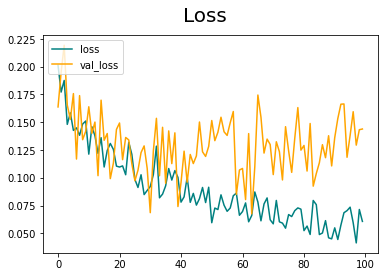

In [86]:
fig = plt.figure()
plt.plot(histS.history['loss'], color='teal', label='loss')
plt.plot(histS.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

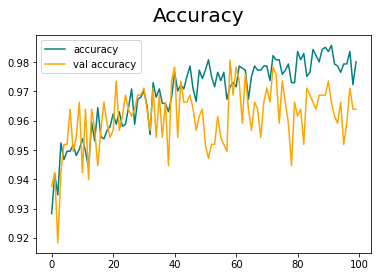

In [87]:
fig = plt.figure()
plt.plot(histS.history['accuracy'], color='teal', label='accuracy')
plt.plot(histS.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


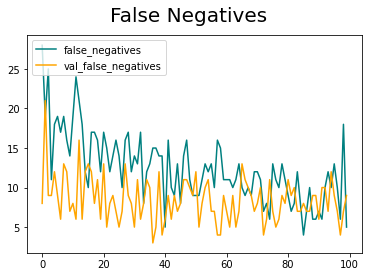

In [88]:
fig = plt.figure()
plt.plot(histS.history['false_negatives'], color='teal', label='false_negatives')
plt.plot(histS.history['val_false_negatives'], color='orange', label='val_false_negatives')
fig.suptitle('False Negatives', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [89]:
modelS.save(os.path.join('/content/drive/MyDrive/malaria_models','modelS.h5'))

### Model 6


#### Set Up
- Softmax Activation
- Less Dropouts

In [90]:
model6 = keras.Sequential([

    # input layer
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(2,2),

      # augment data
    data_augmentation,

    # resize & rescale
    resize_and_rescale,

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation='softmax'),

    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

#### Compile
Parameters 
- optimizer: `adam`
- loss: `binary crossentropy`
- metrics: `accuracy`, `false negatives`
- Total params: `67,373,441`
- Trainable params: `67,373,441`
- Non-trainable params: `0`

In [91]:
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives')])
print(model6.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 sequential_1 (Sequential)   (None, 31, 31, 32)        0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 131072)            0         
                                                                 
 dense_18 (Dense)            (None, 512)               67109376  
                                                      

#### Train

In [92]:
hist6 = model6.fit(x=train, epochs=25, validation_data=val, verbose=1, shuffle=True)

Epoch 1/25


44/44 [==============================] - 8s 108ms/step - loss: 0.6936 - accuracy: 0.4972 - false_negatives: 414.0000 - val_loss: 0.6974 - val_accuracy: 0.4639 - val_false_negatives: 223.0000
Epoch 2/25
44/44 [==============================] - 5s 104ms/step - loss: 0.6940 - accuracy: 0.5142 - false_negatives: 476.0000 - val_loss: 0.6933 - val_accuracy: 0.4615 - val_false_negatives: 224.0000
Epoch 3/25
44/44 [==============================] - 5s 106ms/step - loss: 0.6936 - accuracy: 0.5057 - false_negatives: 374.0000 - val_loss: 0.6953 - val_accuracy: 0.4688 - val_false_negatives: 221.0000
Epoch 4/25
44/44 [==============================] - 5s 105ms/step - loss: 0.6933 - accuracy: 0.5014 - false_negatives: 642.0000 - val_loss: 0.6942 - val_accuracy: 0.4976 - val_false_negatives: 209.0000
Epoch 5/25
44/44 [==============================] - 5s 103ms/step - loss: 0.6939 - accuracy: 0.5121 - false_negatives: 687.0000 - val_loss: 0.6948 - val_accuracy: 0.4712 - val_false_negatives: 220.0000
E

#### Results

In [93]:
hist6.history

{'loss': [0.6936213970184326,
  0.6940406560897827,
  0.693601131439209,
  0.6932634711265564,
  0.6938753128051758,
  0.693672239780426,
  0.6947653293609619,
  0.6924858689308167,
  0.6930792331695557,
  0.6933391094207764,
  0.694437563419342,
  0.6927924752235413,
  0.6931833624839783,
  0.6937490701675415,
  0.6931382417678833,
  0.693711519241333,
  0.6934098601341248,
  0.693730354309082,
  0.693779706954956,
  0.6931707859039307,
  0.6937990784645081,
  0.6940321922302246,
  0.6931977868080139,
  0.6932206749916077,
  0.6939756274223328],
 'accuracy': [0.49715909361839294,
  0.5142045617103577,
  0.5056818127632141,
  0.5014204382896423,
  0.5120738744735718,
  0.5042613744735718,
  0.49147728085517883,
  0.515625,
  0.5142045617103577,
  0.5007102489471436,
  0.4921875,
  0.5085227489471436,
  0.5134943127632141,
  0.5007102489471436,
  0.5099431872367859,
  0.5085227489471436,
  0.5099431872367859,
  0.5085227489471436,
  0.5106534361839294,
  0.5007102489471436,
  0.48934659

#### Testing Precision, Recall, & Binary Accuracy

In [94]:
pre = Precision()
re = Recall()
acc = Accuracy()


In [95]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model6.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 73ms/step
Precision:0.0, Recall:0.0, Accuracy:0.4829545319080353


#### Results Visualization

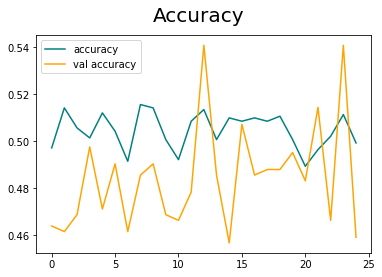

In [96]:
fig = plt.figure()
plt.plot(hist6.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist6.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


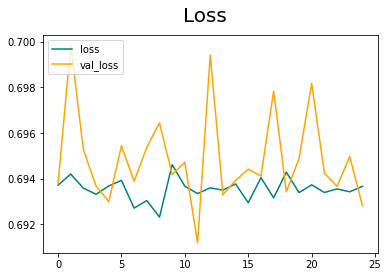

In [80]:
fig = plt.figure()
plt.plot(hist6.history['loss'], color='teal', label='loss')
plt.plot(hist6.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

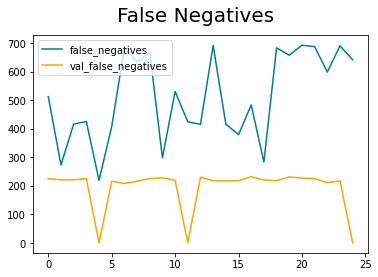

In [81]:
fig = plt.figure()
plt.plot(hist6.history['false_negatives'], color='teal', label='false_negatives')
plt.plot(hist6.history['val_false_negatives'], color='orange', label='val_false_negatives')
fig.suptitle('False Negatives', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Final Model
Trained on the entire dataset.

In [82]:
# kept naming convention as model 5 and ran on all data, did not want to rename and run again
model5 = keras.Sequential([
    # ideally would have early stopping but halts processing for Google Colab

    # input layer
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(2,2),

    # augment data
    data_augmentation,

    # resize & rescale
    resize_and_rescale,

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

#### Compile
Parameters
- optimizer: `adam`
- loss: binary `crossentropy`
- metrics: `accuracy`, `false negatives`
- Total params: `6,479,873`
- Trainable params: `6,479,873`
- Non-trainable params: `0`

In [ ]:
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(name='false_negatives')])
print(model5.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 sequential_1 (Sequential)   (None, 31, 31, 32)        0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                  

#### Train

In [ ]:
hist5 = model5.fit(x=train, epochs=30, validation_data=val, verbose=1, shuffle=True)

Epoch 1/30


603/603 [==============================] - 1507s 2s/step - loss: 0.4574 - accuracy: 0.7603 - false_negatives: 2295.0000 - val_loss: 0.2058 - val_accuracy: 0.9344 - val_false_negatives: 119.0000
Epoch 2/30
603/603 [==============================] - 62s 102ms/step - loss: 0.2231 - accuracy: 0.9289 - false_negatives: 464.0000 - val_loss: 0.1705 - val_accuracy: 0.9509 - val_false_negatives: 77.0000
Epoch 3/30
603/603 [==============================] - 62s 103ms/step - loss: 0.1689 - accuracy: 0.9467 - false_negatives: 355.0000 - val_loss: 0.1603 - val_accuracy: 0.9527 - val_false_negatives: 87.0000
Epoch 4/30
603/603 [==============================] - 62s 102ms/step - loss: 0.1561 - accuracy: 0.9513 - false_negatives: 334.0000 - val_loss: 0.1444 - val_accuracy: 0.9561 - val_false_negatives: 114.0000
Epoch 5/30
603/603 [==============================] - 62s 102ms/step - loss: 0.1492 - accuracy: 0.9519 - false_negatives: 339.0000 - val_loss: 0.1409 - val_accuracy: 0.9577 - val_false_negative

#### Results

In [ ]:
hist5.history

{'loss': [0.4574050009250641,
  0.22311824560165405,
  0.16891247034072876,
  0.15607036650180817,
  0.14915481209754944,
  0.14146196842193604,
  0.13991020619869232,
  0.13891474902629852,
  0.1381821483373642,
  0.13052141666412354,
  0.1326439082622528,
  0.1297820806503296,
  0.12984775006771088,
  0.12776531279087067,
  0.12946650385856628,
  0.1259663701057434,
  0.12341627478599548,
  0.12298821657896042,
  0.12219160795211792,
  0.12309390306472778,
  0.12143556773662567,
  0.1161603033542633,
  0.11417421698570251,
  0.11657021194696426,
  0.11622381955385208,
  0.11584238708019257,
  0.11117934435606003,
  0.1128547266125679,
  0.11250253021717072,
  0.11081965267658234],
 'accuracy': [0.7602611780166626,
  0.9288972020149231,
  0.9467247128486633,
  0.9512852430343628,
  0.9518553018569946,
  0.954809308052063,
  0.9547574520111084,
  0.9561048746109009,
  0.9562085270881653,
  0.9567785859107971,
  0.9568822383880615,
  0.9564158320426941,
  0.9567267894744873,
  0.9578669

#### Precision, Recall, Accuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model5.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 22ms/step
Precision:0.9766213893890381, Recall:0.9536082744598389, Accuracy:0.9655172228813171


#### Results Visualization

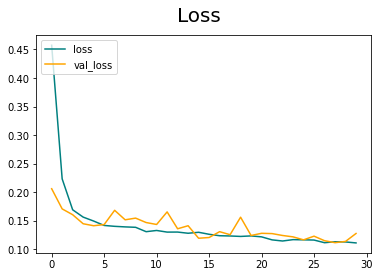

In [ ]:
fig = plt.figure()
plt.plot(hist5.history['loss'], color='teal', label='loss')
plt.plot(hist5.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

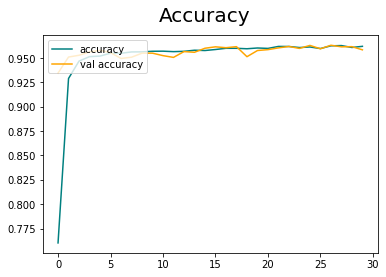

In [ ]:
fig = plt.figure()
plt.plot(hist5.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist5.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


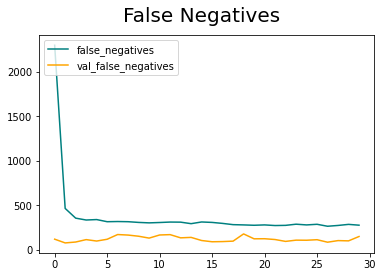

In [ ]:
fig = plt.figure()
plt.plot(hist5.history['false_negatives'], color='teal', label='false_negatives')
plt.plot(hist5.history['val_false_negatives'], color='orange', label='val_false_negatives')
fig.suptitle('False Negatives', fontsize=20)
plt.legend(loc='upper left')
plt.show()

#### Saving Model

## Load Model From File

In [ ]:
new_model = load_model(os.path.join('/content/drive/MyDrive/malaria_models','model5.h5'))

### Visualizing the Final Model

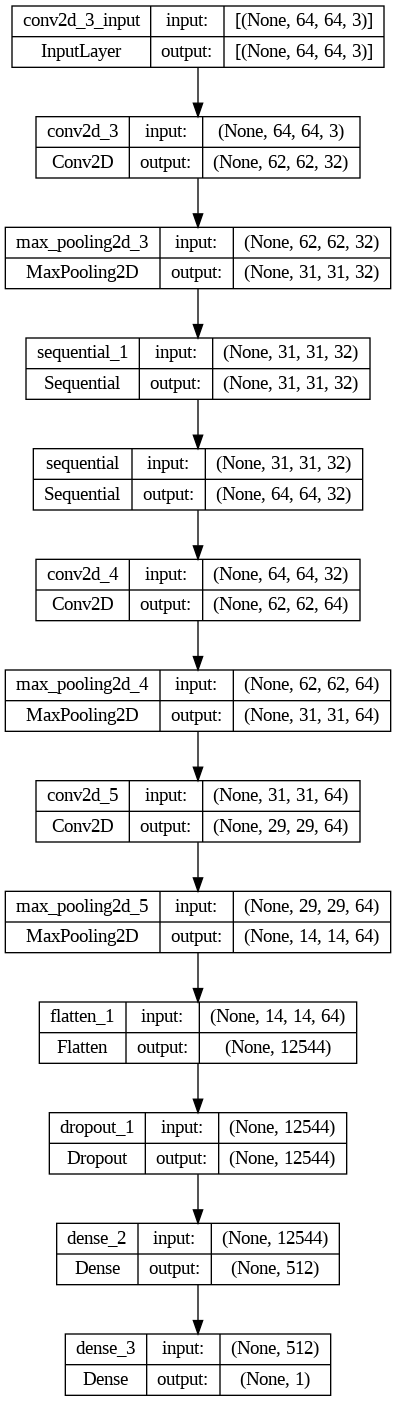

In [ ]:
keras.utils.plot_model(new_model, show_shapes=True)

### Making Predictions on Batches of Images

In [ ]:
batch_size = 32
img_dim = 64
image_size = (img_dim, img_dim)
# loading unseen data to test the model
unseen_dir = '/content/drive/MyDrive/Unseen_Malaria_Images'

unseen_data = tf.keras.utils.image_dataset_from_directory(unseen_dir,
                                                         labels='inferred',
                                                         label_mode='int', 
                                                         color_mode='rgb',
                                                         batch_size=batch_size,
                                                         image_size=image_size,
                                                         shuffle=True,
                                                         seed=42,
                                                         subset=None)

Found 100 files belonging to 2 classes.


In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in unseen_data.as_numpy_iterator():
  X, y = batch
  yhat = new_model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 79ms/step
Precision:0.9615384340286255, Recall:1.0, Accuracy:0.9800000190734863


### Making Predictions on Single Images

In [ ]:
def make_pred_from_img_filepath(model, filepath):
  '''
  input model and filepath to image
  image is resized and converted to batch format
  output prediction value, prediction, & image is displayed
  '''
  imdim = 64 # image dimension
  img = tf.keras.utils.load_img(filepath)  # load image
  inp_arr = tf.keras.utils.img_to_array(img) # convert to array
  mod_arr = np.array([inp_arr]) # convert to batch structure

  resize = tf.keras.layers.Resizing(imdim, imdim) # resize
  resized = resize(mod_arr)

  pred_class = None #initiate class placeholder
  pred = model.predict(resized) #make prediction & fill pred_class
  if pred >= 0.5:
    pred_class = 'Uninfected'
  else:
    pred_class = 'Parasitized'
  return print(f'Prediction Value: {pred[0][0]}\nPrediction: {pred_class}\n'), plt.imshow(img), plt.show()


1/1 [==============================] - 0s 30ms/step
Prediction Value: 0.9818061590194702
Prediction: Uninfected



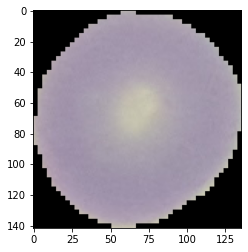

(None, <matplotlib.image.AxesImage at 0x7f6bac76a9d0>, None)

In [ ]:
make_pred_from_img_filepath(model=new_model, filepath='/content/drive/MyDrive/Unseen_Malaria_Images/Uninfected/C241NThinF_IMG_20151207_124643_cell_169.png')

1/1 [==============================] - 0s 31ms/step
Prediction Value: 0.00018532961257733405
Prediction: Parasitized



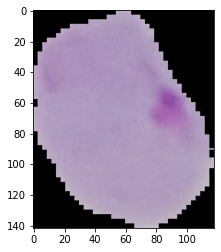

(None, <matplotlib.image.AxesImage at 0x7f6bac783760>, None)

In [ ]:
make_pred_from_img_filepath(new_model, '/content/drive/MyDrive/Unseen_Malaria_Images/Parasitized/C189P150ThinF_IMG_20151203_141901_cell_82.png')